In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv("Clean_UoB_Set01_2025-01-02tapes.csv")

In [3]:
data.head()

,Time,Weighted_Price,Total_Size,Order_Number
0,10.881,267.0,1.0,1.0
1,11.067,269.0,1.0,1.0
2,11.222,267.0,2.0,1.0
3,12.338,270.0,2.0,1.0
4,13.733,267.0,3.0,1.0


In [4]:
data_copy = data[['Time','Weighted_Price']].copy()

In [5]:
data_copy['Time'] = pd.to_datetime(data_copy['Time'], unit='s')

In [6]:
data_copy.set_index('Time',inplace=True)

In [35]:
data_copy

,Weighted_Price
Time,
1970-01-01 00:00:10.881,267.000000
1970-01-01 00:00:11.067,269.000000
1970-01-01 00:00:11.222,267.000000
1970-01-01 00:00:12.338,270.000000
1970-01-01 00:00:13.733,267.000000
...,...
1970-01-01 08:29:54.830,285.333333
1970-01-01 08:29:56.225,286.000000
1970-01-01 08:29:58.085,287.500000


In [8]:
price = data_copy['Weighted_Price'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price)

In [9]:
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [10]:
time_step = 100

In [11]:
X, y = create_dataset(scaled_data, time_step)

In [12]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [13]:
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [14]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 0.0321 - val_loss: 0.0049
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 4/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 5/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 6/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 7/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 11/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 12/100
231/23

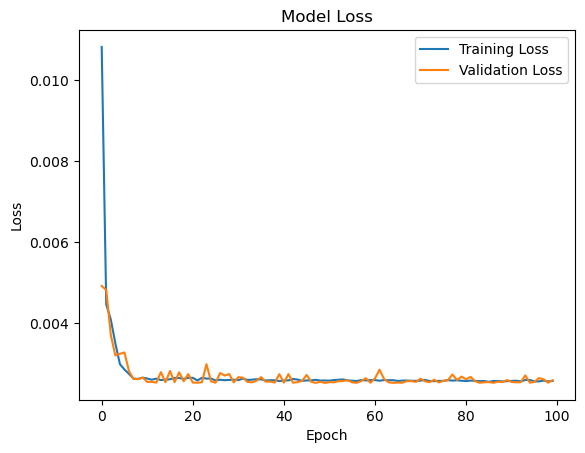

In [17]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')  # Add label for training loss plot
plt.plot(history.history['val_loss'], label='Validation Loss')  # Add label for validation loss plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # This line creates the legend based on the provided labels
plt.title('Model Loss')  # Set the title of the plot
plt.show()

In [18]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse scaling

116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [20]:
rmse = np.sqrt(mean_squared_error(price[split_index+time_step+1:], predictions))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 3.7164110582644927


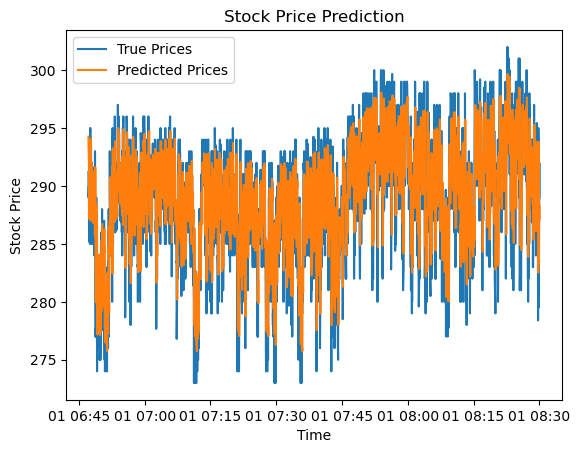

In [41]:
plt.plot(data_copy[split_index+time_step+1:].index, price[split_index+time_step+1:], label='True Prices')
plt.plot(data_copy[split_index+time_step+1:].index, predictions, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()